![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Reference Upper-Air Network for trend analysis

Production date: 11-11-2024

Produced by: V. Ciardini (ENEA), P. Grigioni (ENEA), G. Pace (ENEA), C. Scarchilli (ENEA)

## 🌍 Use case: A study on changing temperature over the Arctic region

## ❓ Quality assessment question
* **Is the tropospheric Arctic warming amplification consistently detectable (across sites) in the GRUAN measurements?**

The evidences, both direct and indirect, indicate a substantial tropospheric warming of the Arctic over recent decades. Furthermore, models project that the region will warm more rapidly than the global average over the remainder of this century, with likely considerable impacts on the environment, ecosystems and human activities. Amplifying feedback mechanisms are based on atmosphere-cryosphere-ocean interactions, with the diminishing of the Arctic Sea ice cover playing a leading role.
Understanding the climate change, and the underlying causes, requires an understanding not just of changes at the surface of the Earth, but throughout the atmospheric column.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note

* GRUAN provides reference-quality measurements with documented uncertainties, making it well-suited to the detailed analysis of Arctic atmospheric column characteristics. Analysis confirms that tropospheric Arctic warming is detectable in GRUAN measurements, though its magnitude and statistical significance vary across sites and seasons, reflecting regional heterogeneity in Arctic amplification. Temporal coverage can also constrain trend analysis, as it depends on when each station joined GRUAN. Nevertheless, the observational frequency is generally high, ranging from two to three launches per week to two to four launches per day, ensuring robust sampling of the atmospheric column.
	
* Positive temperature trends dominate the lower troposphere at all three Arctic stations, with Sodankylä exhibiting the strongest and most significant warming signal. Ny-Ålesund exhibits more uniform but weaker warming, while Barrow shows mixed signals with seasonal cooling episodes. 
	
* Stratospheric trends are generally weak and  less consistent, with only isolated significant signals (e.g. cooling at 13–15 km over Sodankylä), indicating that robust detection of stratospheric changes requires a longer time series. 
	
* Specific humidity trends are more variable than temperature trends. Sodankylä shows clear moistening in the free troposphere and a statistically significant increase in integrated water vapour (IWV). Ny-Ålesund and Barrow, however, exhibit weaker and mostly non-significant trends.
```

## 📋 Methodology
To answer the proposed question, we intend to focus on observations at Ny-Ålesund, Sodankyla and Barrow, the three Arctic GRUAN stations, following part of the methodology of [[1]](https://doi.org/10.1007/s00704-016-1864-0), where a homogenised 22-year Ny-Ålesund radiosonde dataset was analysed to infer changes in vertical temperature and humidity profiles over two decades (1993 to 2014). It should be noted that Ny-Ålesund has been the first radiosonde station certified by GRUAN. The authors found that in NYA, the integrated water vapour (IWV) calculated from radiosonde humidity measurements over two decades, indicates an increase in atmospheric moisture over the years (much faster in winter) and a corresponding warming of the atmospheric column in January and February.

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](insitu_insitu-observations-gruan-reference-network_resolution_q02:section-1)**

**[](insitu_insitu-observations-gruan-reference-network_resolution_q02:section-2)**
* Radiosounding data are interpolated on a regular altitude grid with 50 m vertical resolution; the seasonal profile and standard deviation of temperature and specific humidity are calculated

**[](insitu_insitu-observations-gruan-reference-network_resolution_q02:section-3)** 

**[](insitu_insitu-observations-gruan-reference-network_resolution_q02:section-4)** 

## 📈 Analysis and results

(insitu_insitu-observations-gruan-reference-network_resolution_q02:section-1)=
### 1. Set up and data retrieval for the three stations (NYA, SOD and BAR).

The User will be working with data in netcdf format. To konw more about the GRUAN dataset see [CDS entries documentation section](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=documentation).

**Code:**

* Import CDSAPI credential and packages;
* define parameters (time period, stations, downloaded file directory);
* define request and functions to cache;
* read data and compute functions.

#### Import packages

In [21]:
import os
import cdsapi
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import scipy.stats
import xarray as xr

from scipy.stats import linregress
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

#### Define Parameters

Time range of data series can be set by the User; different stations can be selected by means of Station acronyms (list of GRUAN station acronyms, locations, geographical coordinates and WMO n. are reported in the Product User Guide and Specification for GRUAN Temperature, Relative Humidity and Wind profiles available at [[2]](https://dast.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf)). 

In [22]:
# Time period
start = "2006-05"
stop = "2020-03"

# Stations
stations = ["BAR", "SOD", "NYA"]  # Use None to analyse all stations
assert isinstance(stations, list | None)

# Directory for csv files
csv_dir = "./csv_files"

# CDS credentials
os.environ["CDSAPI_RC"] = os.path.expanduser("~/ciardini_virginia/.cdsapirc")

#### Define request

In [23]:
collection_id = "insitu-observations-gruan-reference-network"
request = {
    "version": "1_0_0",
    "variable": [
        "air_temperature",
        "relative_humidity",
        "air_pressure",
        "altitude",
        "water_vapour_volume_mixing_ratio",
    ],
    "data_format": "netcdf",
}

client = cdsapi.Client(sleep_max=10)
requests = []
for date in pd.date_range(start, stop, freq="1MS"):
    time_request = {"year": date.strftime("%Y"), "month": date.strftime("%m")}
    time_request["day"] = client.client.apply_constraints(
        collection_id, request | time_request
    )["day"]
    if time_request["day"]:
        requests.append(request | time_request)

2025-12-30 15:11:34,365 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


#### Functions to cache

In [24]:
def _reorganize_dataset(ds):
    # Rename
    (varname,) = set(ds["observed_variable"].values)
    ds = ds.rename(observation_value=str(varname)).drop_vars("observed_variable")
    ds = ds.rename(
        {
            var: "_".join([varname, var.replace("_value", "")])
            for var in ds.data_vars
            if var.startswith("uncertainty")
        }
    )
    # Update attrs
    for var, da in ds.data_vars.items():
        match var:
            case "pressure":
                da.attrs["long_name"] = "Pressure"
            case "air_temperature":
                da.attrs["long_name"] = "Temperature"
            case "altitude":
                da.attrs["long_name"] = "Altitude"
            case "relative_humidity":
                da.attrs["long_name"] = "Relative"
            case "water_vapour_mixing_ratio":
                da.attrs["long_name"] = "Mixing"
        for string in ("units", "type"):
            if string in var:
                ds = ds.drop_vars(var)
                (value,) = set(da.values)
                attrs_var = varname if var == string else var.replace("_" + string, "")
                ds[attrs_var].attrs[string] = value
    return ds


def reorganize_dataset(ds):
    for var, da in ds.data_vars.items():
        if np.issubdtype(da.dtype, np.bytes_):
            ds[var].values = np.char.decode(da.values, "utf-8")

    if not ds.sizes["index"]:
        return ds

    datasets = []
    for var, ds in ds.groupby("observed_variable"):
        datasets.append(_reorganize_dataset(ds))
    with xr.set_options(use_new_combine_kwarg_defaults=True):
        return xr.merge(datasets)


def compute_specific_humidity_from_water_vapour_mixing_ratio(
    water_vapour_mixing_ratio,
    molar_mass_water=18.01528,
    molar_mass_dry_air=28.9647,
):
    specific_humidity = (
        (molar_mass_water * water_vapour_mixing_ratio)
        / (molar_mass_dry_air + molar_mass_water * water_vapour_mixing_ratio)
        * 1000
    )
    specific_humidity.attrs = {"long_name": "Specific Humidity", "units": "g/kg"}
    return specific_humidity


def compute_integrated_water_vapour(specific_humidity):
    specific_humidity = specific_humidity / 1.0e3  # g/kg → kg/kg
    delta_altitude = specific_humidity["altitude"].diff("altitude").fillna(0)  # m

    integrated_water_vapour = (specific_humidity * delta_altitude).sum("altitude")
    integrated_water_vapour.attrs = {
        "long_name": "Integrated Water Vapour",
        "units": "kg/m²",
    }
    return integrated_water_vapour


def compute_insitu_profiles(ds):
    ds = reorganize_dataset(ds)

    # Add variables
    ds["specific_humidity"] = compute_specific_humidity_from_water_vapour_mixing_ratio(
        ds["water_vapour_mixing_ratio"]
    )
    ds["time"] = ("index", pd.to_datetime(ds["report_timestamp"]).values)

    # Compute profiles
    subset = ["air_temperature", "relative_humidity", "specific_humidity", "altitude"]
    profiles = []
    for station, ds_station in ds.groupby("primary_station_id"):
        for time, profile in ds_station.groupby("time"):
            profile = profile.swap_dims(index="altitude")[subset]
            profile = profile.sortby("altitude")
            profile = profile.dropna("altitude", how="any", subset=subset)
            profile = profile.drop_duplicates("altitude")
            if (profile["altitude"].diff("altitude") > 2_000).any():
                continue
            profile = profile.interp(altitude=range(50, 30_001, 50))
            profile = profile.expand_dims(time=[time])
            profile = profile.assign_coords(station=("time", [station]))
            profiles.append(profile)
    ds = xr.concat(profiles, "time")

    # Add integrated water vapour
    ds["integrated_water_vapour"] = compute_integrated_water_vapour(
        ds["specific_humidity"]
    )
    return ds

#### Download and transform

In [25]:
ds = download.download_and_transform(
    collection_id,
    requests,
    chunks={"year": 1, "month": 1},
    transform_func=compute_insitu_profiles,
    cached_open_mfdataset_kwargs={"concat_dim": "time", "combine": "nested"},
)
if stations is not None:
    ds = ds.where(ds["station"].isin(stations).compute(), drop=True)
ds = ds.compute()

100%|██████████| 167/167 [00:10<00:00, 16.05it/s]


In [26]:
STATIONS = [
    {
        "name": "Barrow (Utqiaġvik)",
        "abbr": "BAR",
        "lat": 71.29,
        "lon": -156.79,
        "color": "red",
        "marker": "*",
    },
    {
        "name": "Ny-Ålesund",
        "abbr": "NYA",
        "lat": 78.923,
        "lon": 11.923,
        "color": "red",
        "marker": "*",
    },
    {
        "name": "Sodankylä",
        "abbr": "SOD",
        "lat": 67.37,
        "lon": 26.63,
        "color": "red",
        "marker": "*",
    },
]

def plot_arctic_three_stations(
    extent=(-180, 180, 55, 90),
    land_color="#d9d9d9",
    ocean_color="#e6f2ff",
    savepath=None,
    dpi=300
):
    """Crea una mappa polare artica con BAR, NYA e SOD."""
    fig = plt.figure(figsize=(8, 8))
    proj = ccrs.NorthPolarStereo()
    ax = plt.subplot(1, 1, 1, projection=proj)

    # Estensione geografica (Nord del ~55°N)
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Layer geografici
    ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor=land_color)
    ax.add_feature(cfeature.OCEAN.with_scale("110m"), facecolor=ocean_color)
    ax.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.6)
    ax.add_feature(cfeature.BORDERS.with_scale("110m"), linewidth=0.3)

    # Graticola (solo linee, senza etichette)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

    # Cerchi di latitudine (60°, 70°, 80°)
    for lat_circle in (60, 70, 80):
        theta = np.linspace(0, 360, 361)
        ax.plot(theta, [lat_circle]*len(theta),
                transform=ccrs.Geodetic(), color="lightgray", linewidth=0.4)

    # PIAZZAMENTO STAZIONI
    for st in STATIONS:
        ax.plot(st["lon"], st["lat"], st["marker"],
                color=st["color"], markersize=12,
                transform=ccrs.PlateCarree(), label=st["abbr"])
        # Etichette leggermente spostate per evitare sovrapposizioni
        ax.text(st["lon"] + 3, st["lat"] + 1, st["name"],
                transform=ccrs.PlateCarree(),
                fontsize=10, ha="left", va="bottom", color="black",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    ax.set_title("Arctic map: Ny-Ålesund (NYA), Sodankylä (SOD), Barrow/Utqiaġvik (BAR)", fontsize=12)

    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

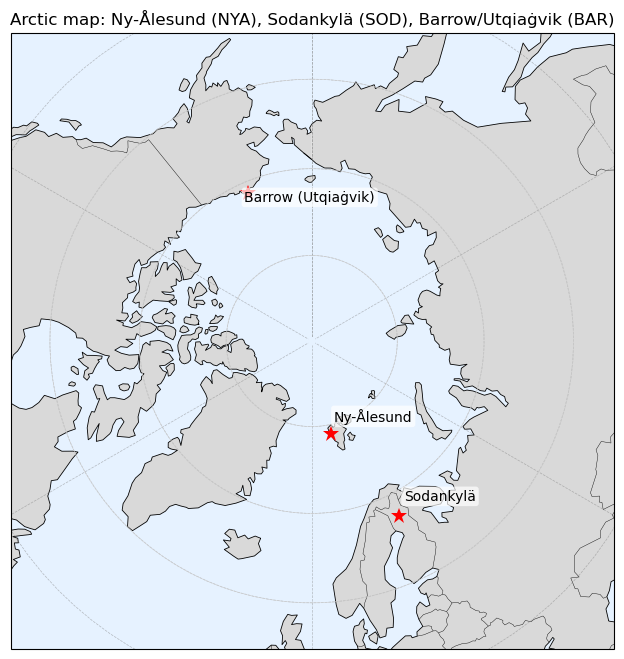

In [27]:
plot_arctic_three_stations()

**Figure 1**. The figure shows a map of the three Arctic GRUAN sites, which represent distinct regional environments within the Arctic.

Although Arctic amplification affects the entire Arctic region, its magnitude varies among different sectors and is strongest in the Eurasian sector of the Arctic Ocean. In general, the greatest amplification occurs in regions experiencing the strongest reductions in sea-ice extent, where albedo-feedback processes are particularly effective. However, regional variations in atmospheric circulation [[3]](https://doi.org/10.1038/s43247-024-01605-2), water vapour, cloudiness, and geographical setting [[4]](https://doi.org/10.3390/rs15041095) also contribute to spatial heterogeneity in Arctic amplification.
The three Arctic GRUAN stations—Barrow (BAR), Sodankylä (SOD), and Ny-Ålesund (NYA)—are located in different environments and therefore provide complementary perspectives on the Arctic atmosphere, particularly in the lower troposphere where interactions with the surface are more intense. NYA is directly influenced by the Arctic Ocean and by the seasonal presence or absence of sea ice. BAR is also affected by conditions over the nearby Beaufort Sea [[5]](https://journals.ametsoc.org/view/journals/clim/36/13/JCLI-D-22-0434.1.xml), although its coastal location means that it is also influenced by the Alaskan interior. In contrast, SOD is located inland on the Scandinavian Peninsula, more than 250 km from the coast, and is therefore only indirectly affected by the Arctic Ocean.

(insitu_insitu-observations-gruan-reference-network_resolution_q02:section-2)=
### 2. Monthly mean temperature and seasonal profiles

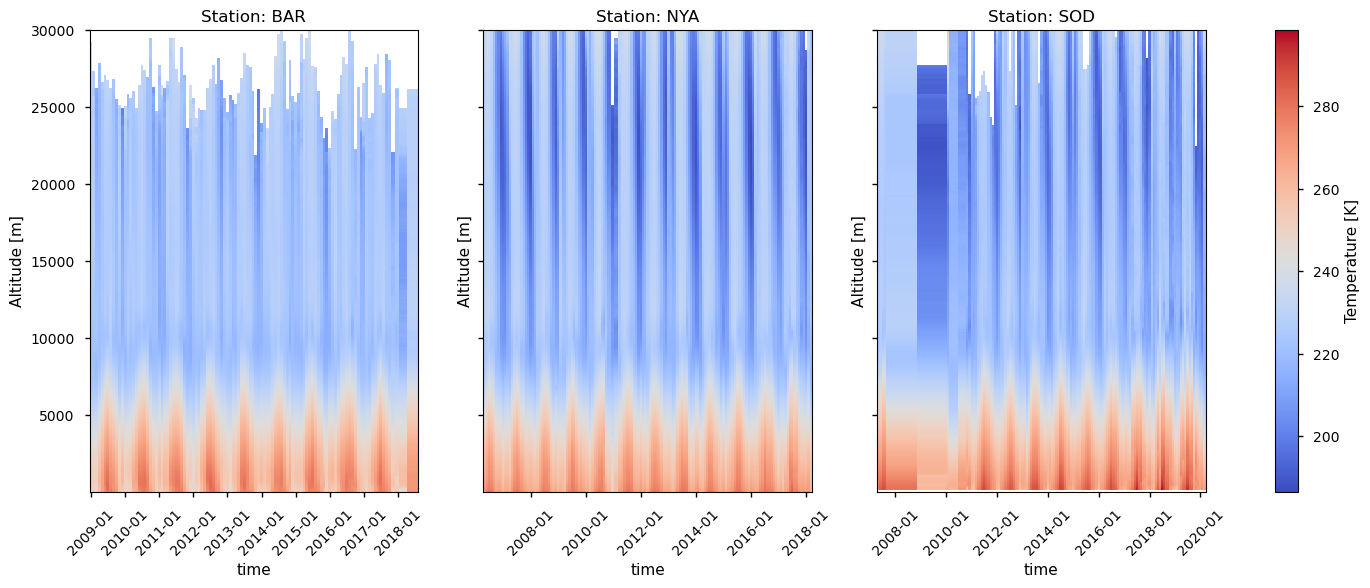

In [30]:
fig, axs = plt.subplots(1, len(set(ds["station"].values)), sharey=True, figsize=(18, 6))
dataarrays = {
    station: da.resample(time="1MS").mean()
    for station, da in ds["air_temperature"].groupby("station")
}
vmin = min(da.min().values for da in dataarrays.values())
vmax = max(da.max().values for da in dataarrays.values())
for ax, (station, da_station) in zip(axs, dataarrays.items()):
    da_station = da_station.dropna("time", how="all")
    pcm = da_station.plot(
        x="time", cmap="coolwarm", vmin=vmin, vmax=vmax, ax=ax, add_colorbar=False
    )
    ax.set_title(f"Station: {station}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="x", rotation=45)
fig.colorbar(pcm, ax=axs, orientation="vertical", label="Temperature [K]")
#_= fig.suptitle("Monthly Mean Temperature")
plt.show()

**Figure 2**. Monthly mean temperature profiles for the three GRUAN stations (BAR, NYA, and SOD), shown in separate panels. Due to limited data availability for SOD prior to 2011, the time series used in the analysis starts from 2011.

The monthly mean temperature profiles exhibit distinct annual cycles at the three Arctic stations. SOD shows the most pronounced annual cycle in tropospheric temperature, consistent with its more continental like climate, whereas NYA displays the weakest annual amplitude due to its oceanic background. A further difference in the vertical temperature structure among the sites appears in the stratosphere, where BAR shows a much weaker annual cycle than NYA and SOD.
These differences are highlighted by the seasonal profiles (Figure 3), which reveal contrasting near-surface thermal structures.

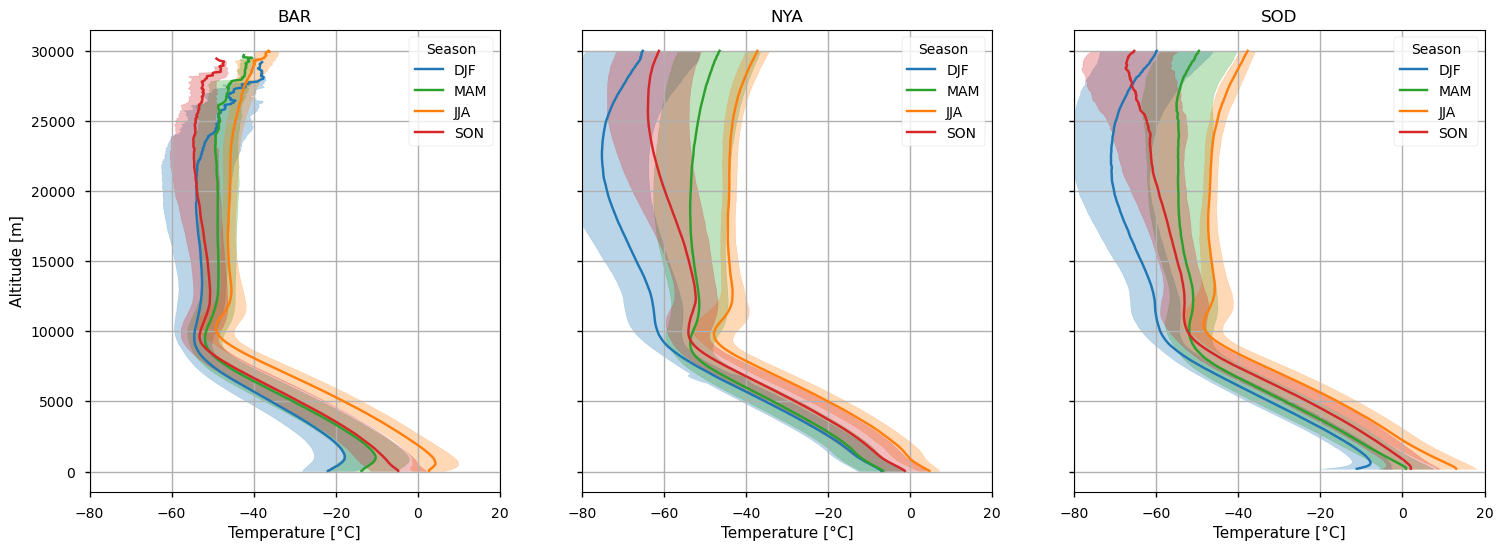

In [31]:
season_colors = {
    "DJF": "tab:blue",
    "MAM": "tab:green",
    "JJA": "tab:orange",
    "SON": "tab:red",
}

# Setup figure
fig, axs = plt.subplots(1, len(set(ds["station"].values)), sharey=True, figsize=(18, 6))
for ax, (station, ds_station) in zip(axs, ds.groupby("station")):
    # Compute seasonal mean
    da = ds_station["air_temperature"] - 273.15  # °C
    grouped = da.groupby("time.season")
    ds_seasonal = xr.merge([grouped.mean().rename("mean"), grouped.std().rename("std")])
    for season, color in season_colors.items():
        # Plot
        ds_season = ds_seasonal.sel(season=season)
        ax.plot(
            ds_season["mean"], ds_season["altitude"], label=f"{season}", color=color
        )
        ax.fill_betweenx(
            ds_season["altitude"],
            ds_season["mean"] - ds_season["std"],
            ds_season["mean"] + ds_season["std"],
            color=color,
            alpha=0.3,
        )
    # Ax settings
    ax.set_title(f"{station}")
    ax.set_xlabel("Temperature [°C]")
   # ax.set_ylabel("Altitude [m]")
    ax.grid()
    ax.legend(title="Season")
    ax.set_xlim(-80, 20)
# Figure settings
axs[0].set_ylabel("Altitude [m]")
#_ = fig.suptitle("Seasonal profiles ±1σ")
plt.show()

**Figure 3**. Seasonal vertical profiles of air temperature (°C) for each station. Lines indicate the seasonal mean (DJF = blue, MAM = green, JJA = orange, SON = red); shaded bands denote ±1 standard deviation computed within each season.

BAR exhibits persistent surface-based inversions throughout the year, except in autumn when both inversion depth and strength decrease markedly. This seasonal weakening is consistent with previous studies attributing reduced inversion intensity to ocean heat release and delayed sea ice formation (e.g.[[5]](https://journals.ametsoc.org/view/journals/clim/36/13/JCLI-D-22-0434.1.xml), [[6]](https://doi.org/10.1111/j.1600-0870.2009.00421.x), [[7]](https://tc.copernicus.org/articles/3/11/2009/)). SOD shows weaker winter inversions than BAR and maintains higher near-surface temperatures than both BAR and NYA across all seasons, consistent with its inland location and reduced maritime cooling (e.g. [[8]](https://doi.org/10.1002/qj.4941)).
At NYA, the evidence of persistent near-surface inversions is generally absent in seasonal profiles; however, previous studies report frequent shallow inversions (≈ 80 % of profiles) under a variety of meteorological conditions ([[1]](https://doi.org/10.1007/s00704-016-1864-0), [[9]](https://doi.org/10.1016/j.atmosres.2021.105530)).
Above about 8 km, near the tropopause and in the lower stratosphere, the thermal structure differs among the three stations, likely reflecting stratospheric circulation and polar-vortex dynamics [[1]](https://doi.org/10.1007/s00704-016-1864-0). BAR tends to exhibit slightly warmer tropopause temperatures and a reduced amplitude of the stratospheric annual cycle, whereas NYA and SOD show more similar stratospheric conditions, consistent with a stronger and more persistent influence of the winter polar vortex in those regions.

(insitu_insitu-observations-gruan-reference-network_resolution_q02:section-3)=
### 3.Temperature anomalies and trends

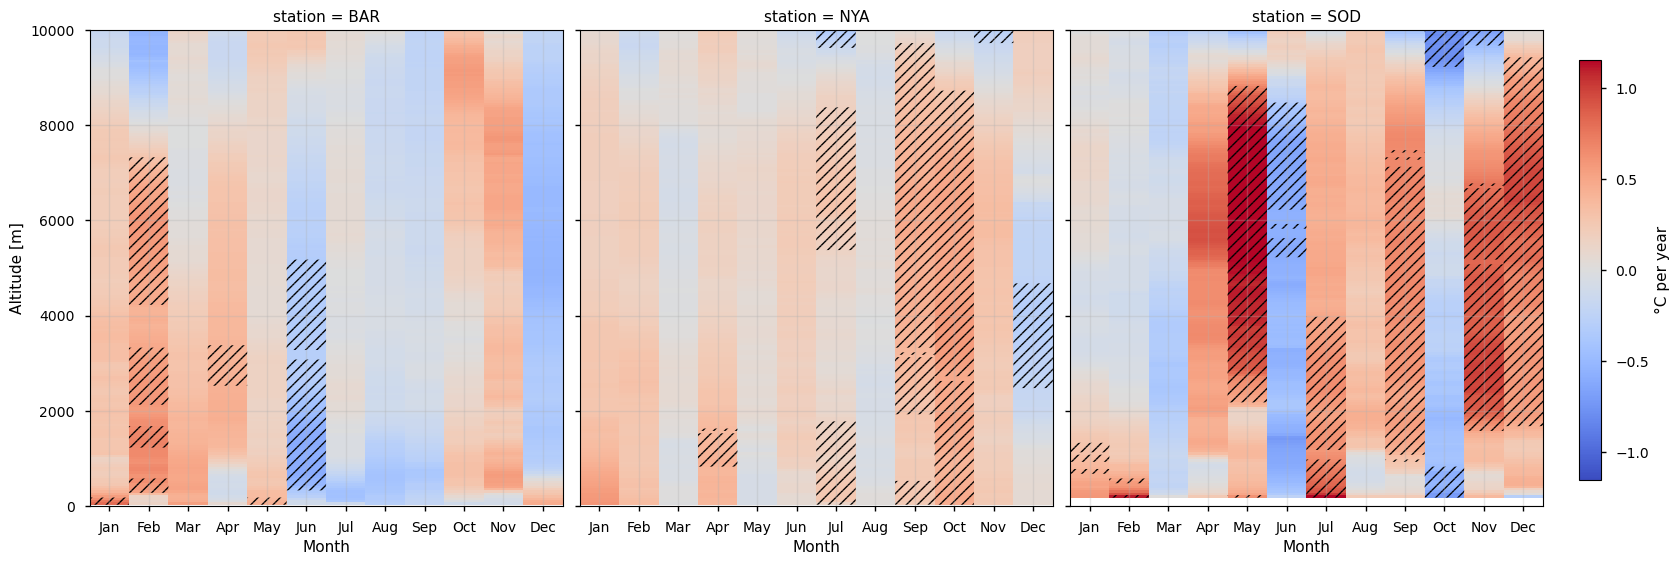

In [32]:
# --- Monthly temperature anomaly trend per station & altitude (SOD from 2011, hatch where significant) ---
import warnings
warnings.filterwarnings(
    "ignore",
    message="The figure layout has changed to tight",
    category=UserWarning,
    module="xarray.plot.facetgrid"
)

import numpy as np
import xarray as xr
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- Linear regression helper: slope (per year) and significance (p-value <= alpha) ----------
def linregress_slope_significant(x, y, alpha=0.1):
    """
    Perform linear regression of y vs x and return slope (per year) and significance (p <= alpha).
    Inputs:
      x: 1D array (numeric years, e.g., 2011, 2012, ...)
      y: 1D array (monthly temperature anomalies aligned with x)
      alpha: significance level (default 0.1)
    Returns:
      slope (units of y per unit of x, here °C/year), significant (bool)
    """
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return np.nan, False
    res = scipy.stats.linregress(x[mask], y[mask])
    return res.slope, bool(np.isfinite(res.pvalue) and (res.pvalue <= alpha))

# ---------- Per-station time filter: remove data before 2011 for SOD (APPLIED BEFORE anomalies) ----------
# Only SOD is filtered from 2011; other stations keep the full available range.
station_time_filters = {
    "SOD": "2011-01-01",
}

# ---------- Build trend dataset for monthly temperature anomalies (°C/year) ----------
datasets = []
for station, da_station in ds["air_temperature"].groupby("station"):
    # Convert to Celsius and compute monthly means (1MS = month start)
    da_c = (da_station - 273.15).resample(time="1MS").mean("time", skipna=True)

    # Apply station-specific filter BEFORE computing anomalies:
    # this ensures climatology and anomalies are computed on the filtered period.
    if station in station_time_filters:
        da_c = da_c.sel(time=slice(station_time_filters[station], None))

    # Group by calendar month to regress within each month across years
    for month, da_month in da_c.groupby("time.month"):
        # Monthly anomalies for this calendar month (remove mean over years on filtered data)
        clim = da_month.mean(dim="time", skipna=True)  # month-specific climatology after filter
        da_anom = da_month - clim                       # anomalies for this month across years

        # Vectorized regression per altitude (and any other non-time dims)
        slope, significant = xr.apply_ufunc(
            linregress_slope_significant,
            da_month["time"].dt.year,  # x: numeric years
            da_anom,                   # y: monthly anomalies (°C)
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[[], []],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float, bool],  # boolean significance
        )

        ds_slope = xr.Dataset(
            {
                "slope": slope,            # °C per year
                "significant": significant # boolean
            }
        ).expand_dims(month=[month], station=[station])

        datasets.append(ds_slope)

# Combine across stations and months by coordinates
ds_slope = xr.combine_by_coords(datasets)

# Copy altitude attributes if present and set metadata
if "altitude" in ds:
    ds_slope["altitude"].attrs = ds["altitude"].attrs

ds_slope["slope"].attrs = {
    "long_name": "Monthly temperature anomaly trend",
    "units": "°C per year",
    "method": "Linear regression of monthly anomalies by calendar month using years as x (SOD from 2011)",
    "significance_alpha": 0.1
}
ds_slope["significant"].attrs = {
    "long_name": "Trend significance (p-value <= alpha)",
    "type": "boolean"
}

# ---------- Robust symmetric color limits for consistent colorbar ----------
qlo = float(ds_slope["slope"].quantile(0.02))
qhi = float(ds_slope["slope"].quantile(0.98))
if np.isfinite(qlo) and np.isfinite(qhi):
    max_abs = max(abs(qlo), abs(qhi))
else:
    max_abs = np.nanmax(np.abs(ds_slope["slope"].values))
VMIN, VMAX = -max_abs, max_abs  # symmetric around zero

# ---------- Facet plot WITHOUT internal colorbar; add a thin external colorbar ----------
facet = ds_slope["slope"].plot(
    col="station",
    x="month",
    figsize=(18, 6),
    cmap="coolwarm",
    add_colorbar=False,     # add external colorbar to avoid overlap
    vmin=VMIN, vmax=VMAX,
)

fig = facet.fig
# Reserve room for a slim colorbar and a top title
fig.subplots_adjust(right=0.86, top=0.90)

# Y-label only on the first panel (first station column)
first_station = facet.col_names[0] if hasattr(facet, "col_names") else None

# Overlay hatching where SIGNIFICANT; set y-limit; month ticks/labels; grid
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    ds_station = ds_slope.sel(sel_dict)

    # Coordinates
    x = ds_station["month"]      # 1..12
    y = ds_station["altitude"]   # meters

    # 2D arrays in (altitude, month) order
    slope_2d  = ds_station["slope"].transpose("altitude", "month").values
    signif_2d = ds_station["significant"].transpose("altitude", "month").values

    # Hatch SIGNIFICANT cells (/// = significant): unmask where significant -> hatch drawn there
    z_masked = np.ma.masked_array(slope_2d, mask=~signif_2d)

    # Transparent faces with hatch pattern overlay
    ax.pcolor(x, y, z_masked, hatch="///", alpha=0)

    # Style: y-limit, ticks/labels, grid
    ax.set_ylim(0, 10000)  # y-axis 0–10,000 m
    ax.set_xlabel("Month")
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    ax.grid(alpha=0.3)

    # Y-label only on first panel
    if first_station is not None and sel_dict.get("station") == first_station:
        ax.set_ylabel("Altitude [m]")
    else:
        ax.set_ylabel("")

# ---------- External thin colorbar on a dedicated axis ----------
norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
mappable = mpl.cm.ScalarMappable(cmap="coolwarm", norm=norm)
mappable.set_array([])  # required for Matplotlib colorbar

# Thin colorbar width (adjust if needed)
cax = fig.add_axes([0.88, 0.15, 0.012, 0.7])  # [left, bottom, width, height]
cb = fig.colorbar(mappable, cax=cax)
cb.set_label("°C per year")

# ---------- Title and show ----------
#fig.suptitle("Temperature Monthly Anomaly Trend (°C per year)", fontsize=16)
plt.show()

**Figure 4**: Monthly temperature anomaly trends (°C per year) as a function of altitude for the GRUAN stations Barrow (BAR), Ny-Ålesund (NYA), and Sodankylä (SOD). Red shading indicates positive trends (warming), blue shading negative trends (cooling), and hatched areas denote statistical significance. 

The monthly tropospheric temperature anomaly trends also differ among the three stations. SOD shows the strongest and most statistically significant warming, concentrated between April and December. However, significant cooling is evident in June and October (with June being statistically significant), indicating complex month-to-month variability in temperature trends.
At NYA, trends are generally weaker, but more consistently uniform throughout the year, with a predominance of positive values and statistically significant tropospheric warming between September and October. Only in December the trends become slightly negative between 2.5 km and 4 km, before returning to positive values in January and February, consistently with [[1]](https://doi.org/10.1007/s00704-016-1864-0).
At BAR, the annual variability of the monthly trends is also high, with a pronounced and statistically significant cooling in June, like SOD. However, unlike SOD, BAR shows tropospheric warming in February and March.

To investigate the vertical structure of the trends, linear trends were computed for four altitude layers representing the near-surface region (0–1 km), the full troposphere (0–6 km), and the lower (13–15 km) and middle (16–23 km) stratosphere. Vertical means were determined by selecting specific altitude intervals and calculating the monthly averages. Monthly anomalies were calculated by removing the climatological average for each month over the entire period. The linear trend of the anomalies was then estimated, including a significance test.

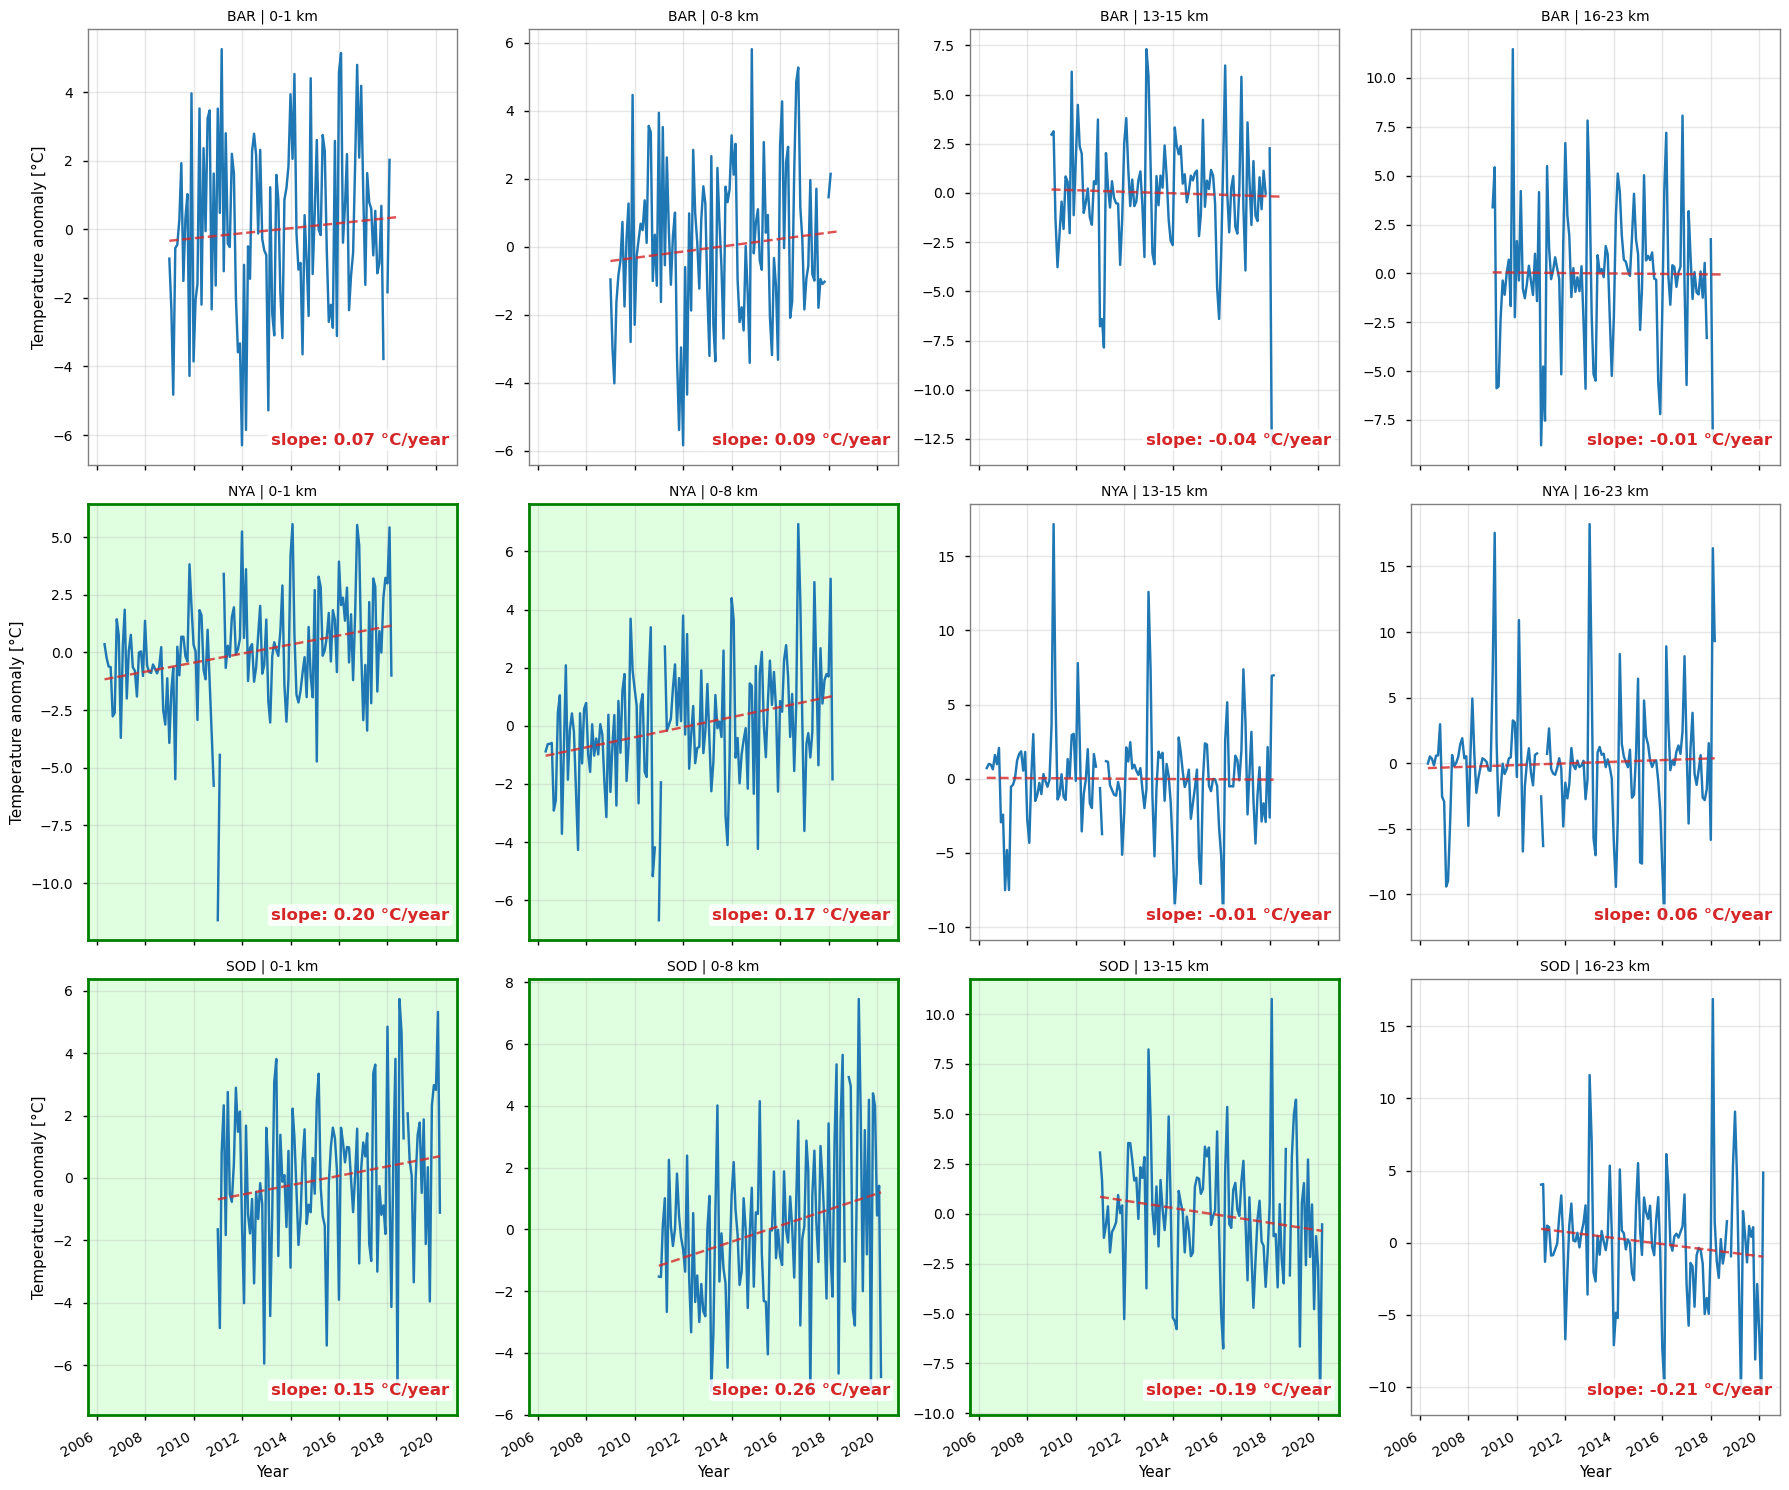

In [33]:
# -------------------------
# INPUT DATA AND PARAMETERS
# -------------------------
# Convert air temperature from K to °C
da_temp = ds["air_temperature"] - 273.15

intervals = {
    "0-1 km":  (0,      1_000),
    "0-8 km":  (0,      8_000),
    "13-15 km":(13_000, 15_000),
    "16-23 km":(16_000, 23_000),
}

# Results dictionary: results[interval_label][station] = {...}
results = {label: {} for label in intervals.keys()}

# ---------------------------------------
# BUILD ANOMALIES AND LINEAR TREND BY BOX
# ---------------------------------------
for station, da_station in da_temp.groupby("station"):
    for label, (low, high) in intervals.items():
        # Select altitude interval. Prefer sel(slice) if altitude is monotonic.
        try:
            da_interval = da_station.sel(altitude=slice(low, high))
            if da_interval.sizes.get("altitude", 0) == 0:
                # Fallback to where in case altitude is not sorted
                da_interval = da_station.where(
                    (da_station["altitude"] >= low) & (da_station["altitude"] <= high),
                    drop=True
                )
        except Exception:
            da_interval = da_station.where(
                (da_station["altitude"] >= low) & (da_station["altitude"] <= high),
                drop=True
            )

        # Skip if no data in interval
        if da_interval.size == 0 or da_interval.sizes.get("altitude", 0) == 0:
            continue

        # Vertical mean over altitude
        da_mean_profile = da_interval.mean(dim="altitude", skipna=True)

        # Monthly mean (1MS = month start)
        da_monthly = da_mean_profile.resample(time="1MS").mean(skipna=True)

        # Station-specific time filter: exclude data before 2011 for BAR
        if station == "SOD":
            da_monthly = da_monthly.sel(time=slice("2011-01-01", None))

        # Convert to pandas DataFrame
        df = pd.DataFrame(
            {"temp": da_monthly.values},
            index=pd.to_datetime(da_monthly["time"].values)
        ).sort_index()

        # Skip short or empty series
        if df["temp"].count() < 3:
            continue

        # -------------------------
        # MONTHLY ANOMALIES
        # -------------------------
        # Monthly climatology over the whole series
        clim = df.groupby(df.index.month)["temp"].mean()
        # Vectorized anomaly: T - monthly climatology
        anomalies = df.copy()
        anomalies["anom"] = df["temp"] - df.index.month.map(clim).values

        # -------------------------
        # LINEAR TREND ON ANOMALIES
        # -------------------------
        x = mdates.date2num(anomalies.index)      # x in days (Matplotlib date numbers)
        y = anomalies["anom"].values

        mask = ~np.isnan(y)
        if mask.sum() >= 2:
            slope_day, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
        else:
            slope_day, intercept, r_value, p_value, std_err = (np.nan, np.nan, np.nan, np.nan, np.nan)

        # Trend line evaluated on the full x axis
        trend_line = intercept + slope_day * x

        # Significance at 10%
        significant = (p_value <= 0.1) if np.isfinite(p_value) else False

        # Save results for plotting
        results[label][station] = {
            "data": anomalies,            # DataFrame with columns: temp, anom
            "slope_day": slope_day,       # °C/day
            "slope_year": slope_day * 365.25,  # °C/year (converted)
            "intercept": intercept,
            "p_value": p_value,
            "r_value": r_value,
            "std_err": std_err,
            "trend_line": trend_line,     # numpy array aligned with anomalies.index
            "significant": significant,
        }

# -------------------------
# PLOTTING
# -------------------------
# Station and interval labels
station_labels = sorted({s for d in results.values() for s in d.keys()})
interval_labels = list(intervals.keys())

if len(station_labels) == 0:
    raise ValueError("No valid data for the requested station-interval combinations.")

fig, axs = plt.subplots(len(station_labels), len(interval_labels),
                        figsize=(18, 15), sharex=True)

# Ensure axs is 2D even if one row/column
if len(station_labels) == 1 and len(interval_labels) == 1:
    axs = np.array([[axs]])
elif len(station_labels) == 1:
    axs = axs[np.newaxis, :]
elif len(interval_labels) == 1:
    axs = axs[:, np.newaxis]

for i, station in enumerate(station_labels):        # rows = stations
    for j, label in enumerate(interval_labels):     # columns = altitude intervals
        ax = axs[i, j]

        # Hide panel if combination is missing
        if station not in results[label]:
            ax.set_visible(False)
            continue

        res = results[label][station]
        df_station = res["data"]
        trend_line = res["trend_line"]
        signif = res["significant"]

        # Plot anomalies
        ax.plot(df_station.index, df_station["anom"], color="tab:blue", label="Anomaly")

        # Plot linear trend
        ax.plot(df_station.index, trend_line, linestyle="--", color="tab:red", alpha=0.8, label="Trend")

        # Highlight significant panels (p <= 0.1)
        if signif:
            ax.set_facecolor("#b3ffb3")  # green background
            ax.patch.set_alpha(0.4)
            for spine in ax.spines.values():
                spine.set_edgecolor("green")
                spine.set_linewidth(2)
        else:
            ax.set_facecolor("white")
            for spine in ax.spines.values():
                spine.set_edgecolor("gray")
                spine.set_linewidth(1)

        # --- Trend label in the bottom-right corner inside each panel ---
        slope_year = res["slope_year"]
        
        # Only annotate if slope is finite and we have a time axis
        if np.isfinite(slope_year) and len(res["trend_line"]) > 0:
            # Text to display (prefix 'slope:' as requested)
            label_txt = f"slope: {slope_year:.2f} °C/year"
        
            # Place it inside the axes, bottom-right, using axes-fraction coordinates
            # (x, y) = (0.98, 0.04) puts the text near the bottom-right with a small margin
            ax.text(
                0.98, 0.04, label_txt,
                transform=ax.transAxes,            # axes fraction coordinates (0..1)
                ha="right", va="bottom",
                fontsize=12, color="tab:red", fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, boxstyle="round,pad=0.2"),
                zorder=5
            )


        # Panel title and grid
        ax.set_title(f"{station} | {label}", fontsize=10)
        ax.grid(True, alpha=0.3)

# Common axis labels
for ax in axs[-1, :]:
    ax.set_xlabel("Year")
for ax in axs[:, 0]:
    ax.set_ylabel("Temperature anomaly [°C]")

# Date formatting
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Figure 5**: Time series of monthly temperature anomalies at four altitude layers (0–1 km, 0–6 km, 13–15 km, and 16–23 km) for the GRUAN stations Barrow (BAR, top row), Ny-Ålesund (NYA, middle row), and Sodankylä (SOD, bottom row). Blue lines represent anomalies, and red dashed lines indicate linear trends, with slopes (°C per year) shown in red text.

Positive trends dominate both SOD and NYA, both below 1 km and throughout the troposphere. BAR also exhibits positive tropospheric trends, albeit of a smaller magnitude than at the other two stations.
In the stratosphere, however, neither the magnitude nor the spatial consistency of the trends indicates a clear, consistent signal across the three stations. The only robust feature is the statistically significant negative trend of −0.19 °C yr⁻¹ between 13 km and 15 km at SOD.

(insitu_insitu-observations-gruan-reference-network_resolution_q02:section-4)=
### 4. Specific humidity and IWV anomalies and trends

#### Specific humidity seasonal profiles and monthly mean trends

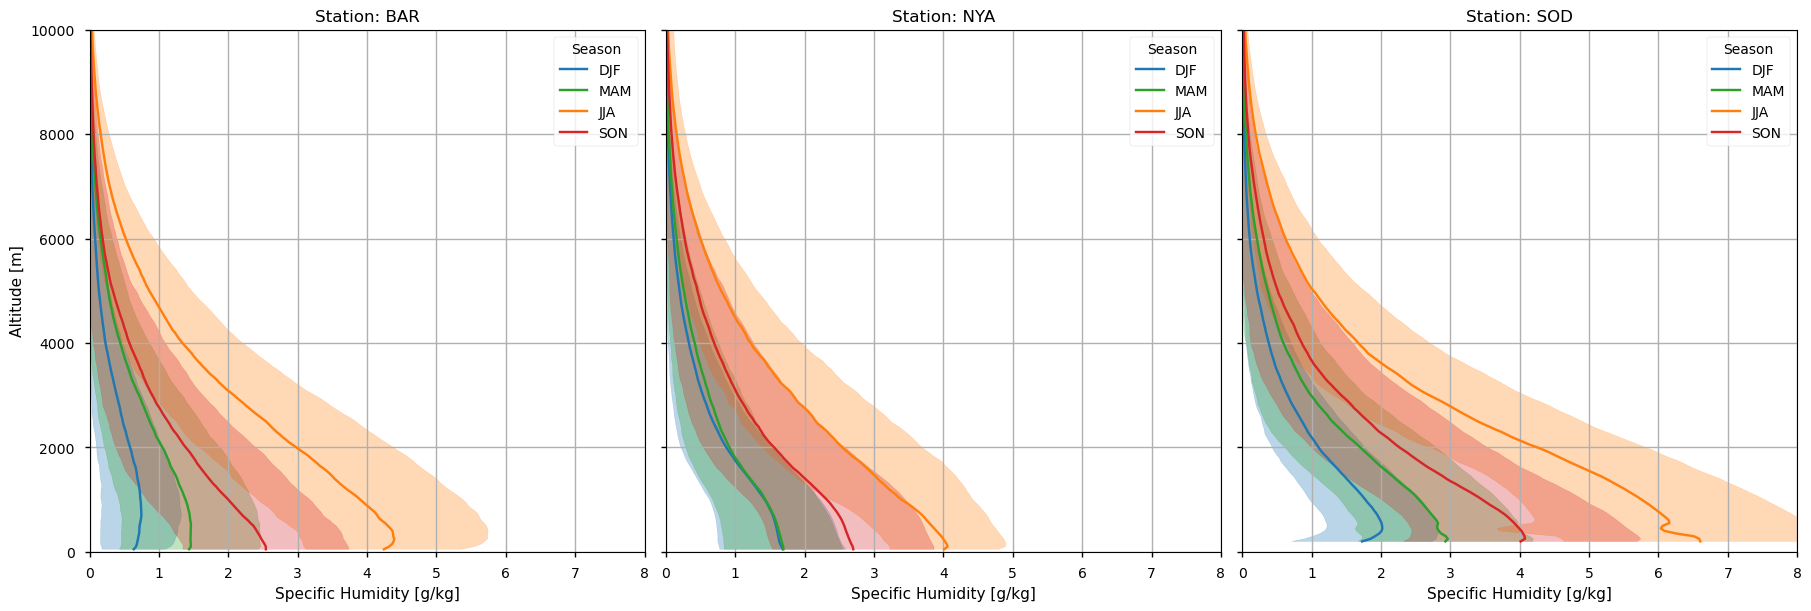

In [34]:
#specific humidity (g/kg)
fig_q, axs_q = plt.subplots(1, len(set(ds["station"].values)), sharey=True, figsize=(18, 6),constrained_layout=True)

for ax, (station, ds_station) in zip(axs_q, ds.groupby("station")):
 
    da_q = ds_station["specific_humidity"]  # g/kg

    grouped_q = da_q.groupby("time.season")
    ds_seasonal_q = xr.merge([
        grouped_q.mean().rename("mean"),
        grouped_q.std().rename("std"),
    ])

    for season, color in season_colors.items():
        ds_season_q = ds_seasonal_q.sel(season=season)

        ax.plot(
            ds_season_q["mean"], ds_season_q["altitude"],
            label=f"{season}", color=color
        )
        ax.fill_betweenx(
            ds_season_q["altitude"],
            ds_season_q["mean"] - ds_season_q["std"],
            ds_season_q["mean"] + ds_season_q["std"],
            color=color, alpha=0.3,
        )

    ax.set_title(f"Station: {station}")
    ax.set_xlabel("Specific Humidity [g/kg]")
    ax.grid()
    ax.legend(title="Season")
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 10000) 

axs_q[0].set_ylabel("Altitude [m]")
#_ = fig_q.suptitle("Seasonal specific humidity profiles ±1σ")
#plt.tight_layout()
plt.show()

**Figure 6**. Seasonal vertical profiles of specific humidity (g/kg) for each station. For each season (DJF = blue, MAM = green, JJA = orange, SON = red), the solid line shows the seasonal mean and the shaded band indicates ±1 standard deviation at each altitude.

The seasonal vertical profiles of specific humidity up to 10 km altitude show clear spatial and seasonal contrasts among the three GRUAN stations. SOD consistently reports higher humidity across all altitudes and seasons than BAR and NYA, mainly because of its inland location and reduced direct influence from the Arctic Ocean. Consistent with the seasonal temperature structure, NYA exhibits the weakest annual variability in specific humidity, reflecting the dominant role of the surrounding ocean.
At all stations, summer (JJA) shows the highest humidity, with steep vertical gradients below about 2 km, likely driven by enhanced surface heating and evaporation. Winter (DJF) presents the driest conditions, particularly above 2 km, due to strong static stability and the limited water vapour holding capacity of cold air. Variability bands widen in summer, suggesting an enhanced role of synoptic-scale systems and local convection. Seasonal humidity profiles in the Arctic are influenced by a combination of large-scale circulation and local processes such as radiation, cloud formation, and turbulence [[10]](https://wcd.copernicus.org/articles/2/1263/2021/).

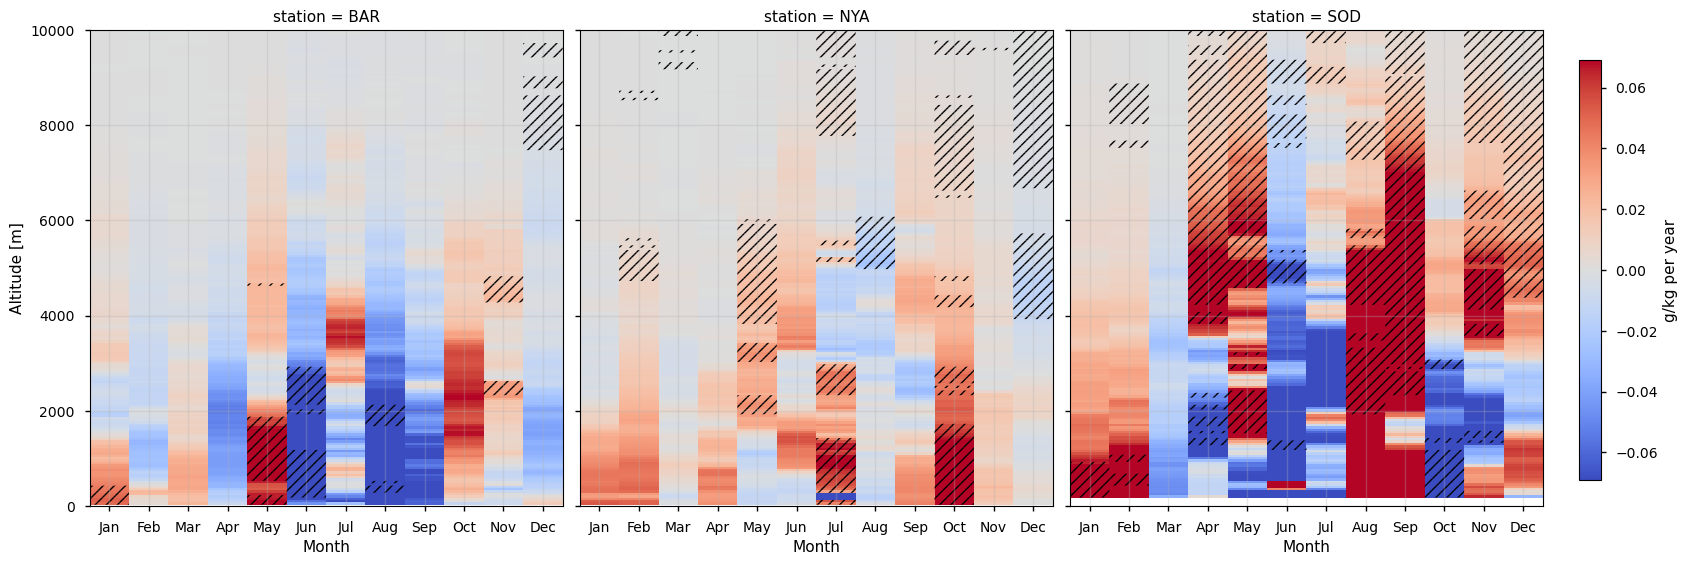

In [35]:
# --- Specific humidity monthly anomaly trend per station & altitude (same style as temperature, thinner colorbar) ---
import warnings
warnings.filterwarnings(
    "ignore",
    message="The figure layout has changed to tight",
    category=UserWarning,
    module="xarray.plot.facetgrid"
)

import numpy as np
import xarray as xr
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- Helper: linear regression returning slope and significance (p-value <= alpha) ----------
def linregress_slope_significant(x, y, alpha=0.1):
    """
    Perform linear regression of y vs x and return slope and significance.
    Inputs:
      x: 1D array (years: 2011, 2012, ...)
      y: 1D array (specific humidity values aligned with x)
      alpha: significance level, default 0.1
    Returns:
      slope (units of y per unit of x), significant (bool, True if p-value <= alpha)
    """
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 2:
        return np.nan, False
    res = scipy.stats.linregress(x[mask], y[mask])
    return res.slope, bool(np.isfinite(res.pvalue) and (res.pvalue <= alpha))

# ---------- Per-station time filters (start date inclusive) ----------
station_time_filters = {
    "SOD": "2011-01-01",   # apply SOD from 2011 as requested
    # add others if needed, e.g., "BAR": "2011-01-01"
}

# ---------- Build trend dataset for specific humidity (assumed in g/kg) ----------
datasets_q = []
for station, da_station in ds["specific_humidity"].groupby("station"):
    # Monthly mean (1MS = month start); keep native units (g/kg)
    da_q = da_station.resample(time="1MS").mean("time")

    # Apply station-specific time filter if defined
    if station in station_time_filters:
        da_q = da_q.sel(time=slice(station_time_filters[station], None))

    # Group by calendar month: compute one slope per (altitude, month)
    for month, da_month in da_q.groupby("time.month"):
        slope, significant = xr.apply_ufunc(
            linregress_slope_significant,
            da_month["time"].dt.year,    # x: numeric years
            da_month,                    # y: specific humidity (g/kg)
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[[], []],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float, bool],  # boolean significance
        )

        ds_slope_q = xr.Dataset(
            {
                "slope": slope,            # g/kg per year (since x=year)
                "significant": significant # boolean
            }
        ).expand_dims(month=[month], station=[station])

        datasets_q.append(ds_slope_q)

# Combine all partial datasets by coordinates
ds_slope_q = xr.combine_by_coords(datasets_q)

# Copy altitude attributes if present and add metadata to variables
if "altitude" in ds:
    ds_slope_q["altitude"].attrs = ds["altitude"].attrs

ds_slope_q["slope"].attrs = {
    "long_name": "Specific humidity trend",
    "units": "g/kg per year",
    "method": "Linear regression on monthly series by calendar month using years as x",
    "significance_alpha": 0.1
}
ds_slope_q["significant"].attrs = {
    "long_name": "Trend significance (p-value <= alpha)",
    "type": "boolean"
}

# ---------- Compute robust symmetric color limits (ensure consistent external colorbar) ----------
qlo = float(ds_slope_q["slope"].quantile(0.02))
qhi = float(ds_slope_q["slope"].quantile(0.98))
max_abs = max(abs(qlo), abs(qhi))
VMIN, VMAX = -max_abs, max_abs  # symmetric color limits around zero

# ---------- Facet plot WITHOUT internal colorbar; add an external colorbar (same layout as temperature) ----------
facet_q = ds_slope_q["slope"].plot(
    col="station",
    x="month",
    figsize=(18, 6),
    cmap="coolwarm",
    add_colorbar=False,      # avoid overlap; we will add a right-side colorbar
    vmin=VMIN, vmax=VMAX,    # use robust symmetric limits computed above
)

# Reserve right margin for colorbar and top margin for title (same as temperature)
fig = facet_q.fig
fig.subplots_adjust(right=0.86, top=0.90)

# Identify the first station (first column) to set y-label only there
first_station = facet_q.col_names[0] if hasattr(facet_q, "col_names") else None

# Overlay hatching on SIGNIFICANT cells; limit y-axis; set month ticks/labels; add grid
for ax, sel_dict in zip(facet_q.axs.flatten(), facet_q.name_dicts.flatten()):
    ds_station_q = ds_slope_q.sel(sel_dict)

    # Coordinates
    x = ds_station_q["month"]            # 1..12
    y = ds_station_q["altitude"]         # altitude in meters

    # 2D arrays as (altitude, month)
    slope_2d  = ds_station_q["slope"].transpose("altitude", "month").values
    signif_2d = ds_station_q["significant"].transpose("altitude", "month").values

    # Hatch SIGNIFICANT cells (/// = significant): unmask where significant -> hatch drawn there
    z_masked = np.ma.masked_array(slope_2d, mask=~signif_2d)

    # Draw transparent faces with hatch pattern on the same grid
    ax.pcolor(x, y, z_masked, hatch="///", alpha=0)

    # Match temperature plot styling
    ax.set_ylim(0, 10000)  # y-axis 0–10,000 m
    ax.set_xlabel("Month")
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    ax.grid(alpha=0.3)

    # Y-label only on the first panel (first station column)
    if first_station is not None and sel_dict.get("station") == first_station:
        ax.set_ylabel("Altitude [m]")
    else:
        ax.set_ylabel("")

# ---------- External colorbar on a dedicated axis (thinner width) ----------
norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
mappable = mpl.cm.ScalarMappable(cmap="coolwarm", norm=norm)
mappable.set_array([])  # required for Matplotlib colorbar

# Make the colorbar thinner by reducing its axis width (from 0.02 to 0.012)
cax = fig.add_axes([0.88, 0.15, 0.012, 0.7])  # [left, bottom, width, height] (thinner width)
cb = fig.colorbar(mappable, cax=cax)
cb.set_label("g/kg per year")

# ---------- Title and show ----------
#fig.suptitle("Specific Humidity Monthly Trend (g/kg per year)", fontsize=16)
plt.show()

**Figure 7**. Monthly trends of specific humidity (g/kg per year) as a function of altitude for the GRUAN stations Barrow (BAR), Ny-Ålesund (NYA), and Sodankylä (SOD). Red shading indicates positive trends (increasing humidity), blue shading negative trends (decreasing humidity), and hatched areas denote statistical significance.

In general, the trends in specific humidity show much greater variability than the temperature trends (Figure 7), in terms of both magnitude and vertical structure.
SOD exhibits pronounced positive trends in spring and late summer at most altitudes, whereas NYA shows weaker, more uniform moistening throughout the year. Notably, six months out of twelve show statistically significant positive trends between 4 km and 10 km at SOD, indicating a clear increase in free-tropospheric water vapour content, especially during the months preceding and following the short Arctic summer (April–May and August–September).
By contrast, BAR exhibits more variable behaviour, with alternating moistening and drying signals in different months and at different altitudes.

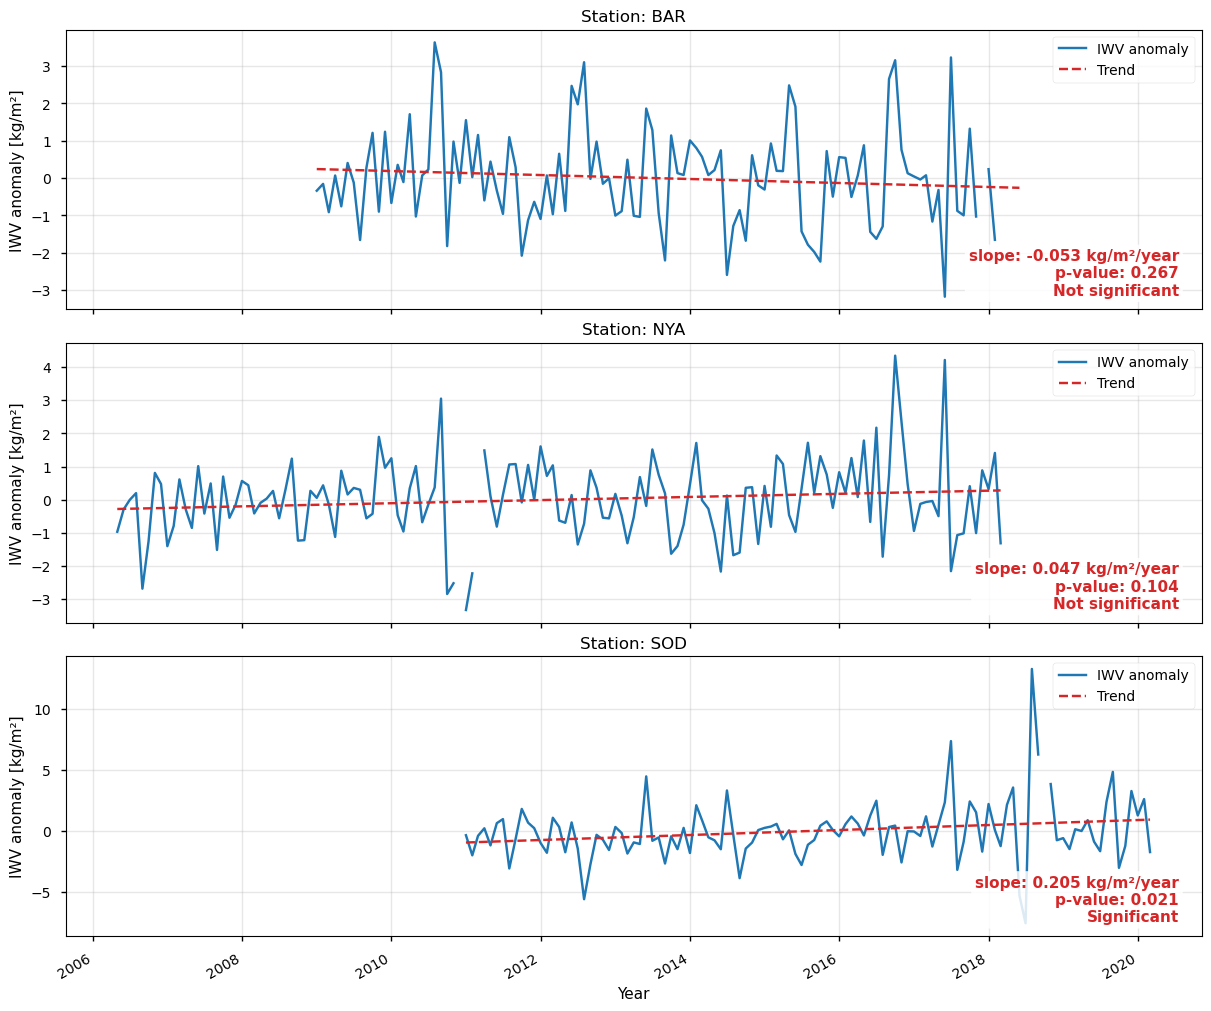

In [36]:
# --- IWV from dataset ---
da_iwv = ds["integrated_water_vapour"]

results_iwv = {}

for station, da_station in da_iwv.groupby("station"):
    # Monthly mean (1MS = month start)
    da_monthly = da_station.resample(time="1MS").mean()

    # --- Station-specific time filter: remove data before 2011 for SOD ---
    # Apply BEFORE climatology/anomalies to keep computations consistent with the target period.
    if station == "SOD":
        da_monthly = da_monthly.sel(time=slice("2011-01-01", None))

    # Convert to pandas DataFrame
    df = pd.DataFrame(
        {"iwv": da_monthly.values},
        index=pd.to_datetime(da_monthly["time"].values)
    ).sort_index()

    # Skip short series
    if df["iwv"].count() < 3:
        continue

    # --- Monthly climatology over the filtered period ---
    climatology = df.groupby(df.index.month)["iwv"].mean()

    # --- Monthly anomalies (vectorized) ---
    anomalies = df.copy()
    anomalies["anom"] = df["iwv"] - df.index.month.map(climatology).values

    # --- Linear trend on anomalies using Matplotlib date numbers (days) ---
    x = mdates.date2num(anomalies.index)  # x in days
    y = anomalies["anom"].values          # anomalies in kg/m²
    mask = np.isfinite(y)

    if mask.sum() >= 2:
        slope_day, intercept, _, p_value, _ = linregress(x[mask], y[mask])
    else:
        slope_day, intercept, p_value = (np.nan, np.nan, np.nan)

    # Trend line (evaluate on full x)
    trend_line = intercept + slope_day * x

    # Convert slope from kg/m² per day to kg/m² per year
    slope_year = slope_day * 365.25

    results_iwv[station] = {
        "data": anomalies,
        "trend_line": trend_line,
        "slope_year": slope_year,    # kg/m² per year
        "p_value": p_value,
        "significant": (p_value <= 0.1) if np.isfinite(p_value) else False,
    }

# --- Plot (use constrained_layout to avoid tight_layout warnings) ---
n_panels = len(results_iwv)
fig, axs = plt.subplots(
    n_panels, 1,
    figsize=(12, 10),
    sharex=True,
    constrained_layout=True  # <- use constrained layout instead of tight_layout
)

# Normalize axs to list if single panel
if n_panels == 1:
    axs = [axs]

for ax, (station, res) in zip(axs, results_iwv.items()):
    anomalies = res["data"]
    slope_year = res["slope_year"]
    p_value = res["p_value"]
    signif = res["significant"]
    trend_line = res["trend_line"]

    # Plot anomalies
    ax.plot(anomalies.index, anomalies["anom"], color="tab:blue", label="IWV anomaly")

    # Plot linear trend
    ax.plot(anomalies.index, trend_line, linestyle="--", color="tab:red", label="Trend")

    # Panel title in English
    ax.set_title(f"Station: {station}")

    # Grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend()

    # --- Bottom-right annotation inside each panel ---
    if np.isfinite(slope_year) and len(trend_line) > 0:
        label_txt = (
            f"slope: {slope_year:.3f} kg/m²/year\n"
            f"p-value: {p_value:.3f}\n"
            f"{'Significant' if signif else 'Not significant'}"
        )
        ax.text(
            0.98, 0.04, label_txt,
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=11, color="tab:red", fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, boxstyle="round,pad=0.25"),
            zorder=5
        )

# Common axis labels (English)
axs[-1].set_xlabel("Year")
for ax in axs:
    ax.set_ylabel("IWV anomaly [kg/m²]")

# Date formatting
fig.autofmt_xdate()

# Optional figure title (works fine with constrained_layout)
# fig.suptitle("IWV anomalies and linear trend by station", fontsize=16)

plt.show()

**Figure 8**. Time series of monthly anomalies of integrated water vapor (IWV, kg/m²) for the GRUAN stations Barrow (BAR, top), Ny-Ålesund (NYA, middle), and Sodankylä (SOD, bottom). Blue lines represent IWV anomalies, and red dashed lines indicate linear trends, with slope and p-value reported in red text. 

In conclusion, the analysis of trends in specific humidity was performed by computing the monthly anomalies and linear trends of integrated water vapour (IWV) for the three stations. While trends at BAR and NYA are weak and not statistically significant, SOD exhibits a statistically significant positive trend (0.205 kg m⁻² yr⁻¹, p = 0.021). This finding aligns with the observed monthly specific humidity trends, suggesting an overall increase in atmospheric moisture at this continental location.

## ℹ️ If you want to know more

### Key resources

[CDS entries](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=overview), `In situ temperature, relative humidity and wind profiles from 2006 to March 2020 from the GRUAN reference network`

external pages:

[GRUAN website](https://www.gruan.org/), `GCOS Reference Upper-Air Network`

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
* [Xarray](https://pypi.org/project/xarray/) for working with multidimensional arrays in Python
* [Matplotlib](https://pypi.org/project/matplotlib/) for visualization in Python 
* [Scipy](https://pypi.org/project/scipy/) for statistics in Python

### References

[[1]](https://doi.org/10.1007/s00704-016-1864-0) Maturilli, M., Kayser, M. Arctic warming, moisture increase and circulation changes observed in the Ny-Ålesund homogenized radiosonde record. Theor Appl Climatol 130, 1–17 (2017). https://doi.org/10.1007/s00704-016-1864-0

[[2]](https://dast.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf) Product User Guide and Specification for GRUAN Temperature, Relative Humidity and Wind profiles.

[[3]](https://doi.org/10.1038/s43247-024-01605-2) Yu, Q., Wu, B. & Zhang, W. The atmospheric connection between the Arctic and Eurasia is underestimated in simulations with prescribed sea ice. Commun Earth Environ 5, 435 (2024). https://doi.org/10.1038/s43247-024-01605-2

[[4]](https://doi.org/10.3390/rs15041095) Yang, M., Qiu, Y., Huang, L., Cheng, M., Chen, J., Cheng, B., & Jiang, Z. (2023). Changes in Sea Surface Temperature and Sea Ice Concentration in the Arctic Ocean over the Past Two Decades. Remote Sensing, 15(4), 1095. https://doi.org/10.3390/rs15041095

[[5]](https://journals.ametsoc.org/view/journals/clim/36/13/JCLI-D-22-0434.1.xml) Ballinger, T. J., U. S. Bhatt, P.A. Bieniek, B. Brettschneider, R. T. Lader, J.S. Littell, R.L. Thoman, C.F. Waigl, J. E. Walsh, M. A. Webster (2023) Alaska Terrestrial and Marine Climate Trends, 1957–2021. J. Climate, 36, 4375–4391, https://doi.org/10.1175/JCLI-D-22-0434.1

[[6]](https://doi.org/10.1111/j.1600-0870.2009.00421.x) Overland, J.E. and Wang, M. (2010), Large-scale atmospheric circulation changes are associated with the recent loss of Arctic sea ice. Tellus A, 62: 1-9. https://doi.org/10.1111/j.1600-0870.2009.00421.x

[[7]](https://tc.copernicus.org/articles/3/11/2009/) Serreze, M. C., Barrett, A. P., Stroeve, J. C., Kindig, D. N., and Holland, M. M.: The emergence of surface-based Arctic amplification, The Cryosphere, 3, 11–19, https://doi.org/10.5194/tc-3-11-2009, 2009.

[[8]](https://doi.org/10.1002/qj.4941) Remes, T., Køltzow, M., & Kähnert, M. (2025). Spatial variability of near‐surface air temperature in the Copernicus Arctic regional reanalysis. Quarterly Journal of the Royal Meteorological Society, 151.

[[9]](https://doi.org/10.1016/j.atmosres.2021.105530) Wang, D., Guo, J., Xu, H., Li, J., Lv, Y., Solanki, R., ... & Rinke, A. (2021). Vertical structures of temperature inversions and clouds derived from high-resolution radiosonde measurements at Ny-Ålesund, Svalbard. Atmospheric Research, 254, 105530.

[[10]](https://wcd.copernicus.org/articles/2/1263/2021/) Nygård, T., Tjernström, M., & Naakka, T. (2021). Winter thermodynamic vertical structure in the Arctic atmosphere linked to large scale circulation.